In [1]:
!pip3 install --upgrade torch
!pip3 install opencv-python numpy matplotlib pillow 

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Requirement already up-to-date: torch in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages (1.9.0)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import urllib.request
from PIL import Image
import tempfile
import subprocess
import os

In [4]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

Using cache found in /Users/sesh/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/sesh/.cache/torch/hub/intel-isl_MiDaS_master


In [5]:
def read_image(filepath, code=cv2.COLOR_BGR2RGB):
    img = cv2.imread(filepath)
    return cv2.cvtColor(img, code)

def get_image_without_rotation(filepath):
    # writing to a tmpfile and reading it back seems to fix the rotation, which 'rembg' is not able to process. 
    tmpfilepath = tempfile.NamedTemporaryFile().name+'.jpg'
    print(tmpfilepath)
    cv2.imwrite(tmpfilepath, cv2.imread(filepath))
    return read_image(tmpfilepath), tmpfilepath

def to_watercolor_img(img: np.ndarray):
    # apply morphology open to smooth the outline
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (24,24))
    morph = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    # brighten dark regions
    return cv2.normalize(morph,None,40,255,cv2.NORM_MINMAX)

def to_depth_img(img):
    input_batch = transform(img).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    return prediction.cpu().numpy()

def to_foreground_mask(filepath):
    tmpfilepath = tempfile.NamedTemporaryFile().name+'.png'
    os.system(f"cat {filepath} | rembg > {tmpfilepath}") # fix.hacky
    alpha = Image.open(tmpfilepath).split()[-1]
    return np.array(alpha)

def display_img(img):
    plt.imshow(img)
    plt.show()

def normalize_0_1(img):
    tmp = img.reshape(-1)
    tmp = tmp - min(tmp)
    tmp = tmp/max(tmp)
    return tmp.reshape(img.shape)

def to_3d_array(array_2d):
    as_flat = array_2d.reshape(-1)
    return np.array(list(zip(as_flat, as_flat, as_flat))).reshape((*array_2d.shape, 3))

def save_image(array, path):
    Image.fromarray(array).save(path, quality=100)

/var/folders/xq/h7xm6r953034zvl_jflncpq00000gn/T/tmpv9fye1mi.jpg


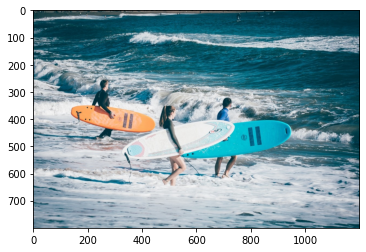

In [6]:
# INPUT

# surfers
input_filepath = f"{os.getcwd()}/surfers.jpg"
input_img, input_filepath = get_image_without_rotation(input_filepath)
display_img(input_img)

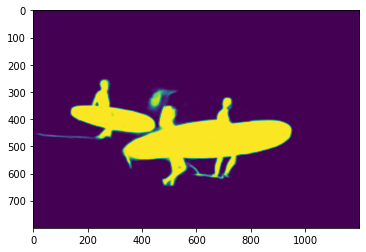

In [7]:
# FOREGROUND
foreground_mask = normalize_0_1(to_foreground_mask(input_filepath))
display_img(foreground_mask)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


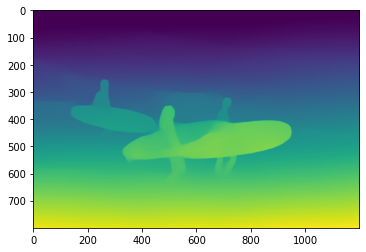

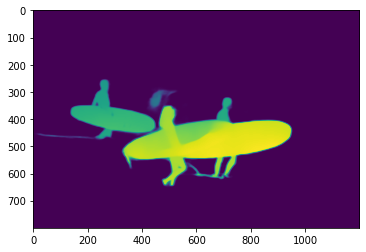

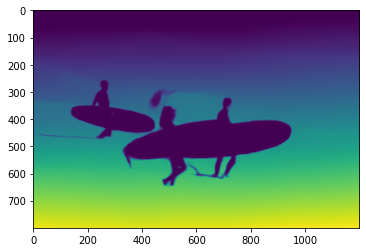

0.5651076431367912 0.29931899905204773


In [8]:
# DEPTH
depth_img = normalize_0_1(to_depth_img(input_img))
display_img(depth_img)
foreground_depth = depth_img*foreground_mask
display_img(foreground_depth)
foreground_depth_flat = foreground_depth.reshape(-1)
interpolation_start_depth = np.percentile(foreground_depth_flat[foreground_depth_flat!=0],50)

background_depth = depth_img*(1-foreground_mask)
display_img(background_depth)
background_depth_flat = background_depth.reshape(-1)
interpolation_stop_depth = min(interpolation_start_depth, np.percentile(background_depth_flat[background_depth_flat!=0],50))

print(interpolation_start_depth, interpolation_stop_depth)

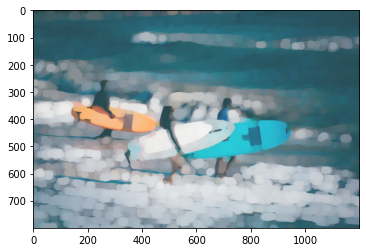

In [9]:
# WATERCOLOR
watercolor_img = to_watercolor_img(input_img)
display_img(watercolor_img)

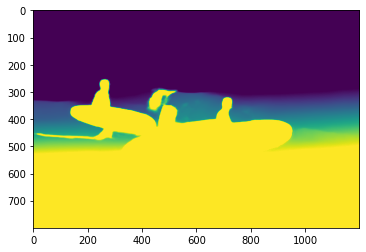

In [10]:
# IMAGES MASK

interpolation_width = interpolation_start_depth - interpolation_stop_depth
def squish(depth_val):
    if depth_val>interpolation_start_depth:
        return 1.
    elif depth_val <= interpolation_stop_depth:
        return 0.
    return min(1., (depth_val - interpolation_stop_depth)/interpolation_width)


mask = np.ndarray(np.vectorize(squish)(foreground_mask + depth_img).shape)
cv2.imwrite('interpolation_mask.jpg', np.uint8(255*mask))
display_img(mask)

In [11]:
# R->L gradient to use for background image

def get_gradient_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T

def get_gradient_3d(width, height, start_list, stop_list, is_horizontal_list):
    result = np.zeros((height, width, len(start_list)), dtype=np.float)

    for i, (start, stop, is_horizontal) in enumerate(zip(start_list, stop_list, is_horizontal_list)):
        result[:, :, i] = get_gradient_2d(start, stop, width, height, is_horizontal)

    return result

array = get_gradient_3d(input_img.shape[1], input_img.shape[0], (0, 0, 0), (255, 255, 255), (True, True, True))
gradient = Image.fromarray(np.uint8(array)).convert("L")

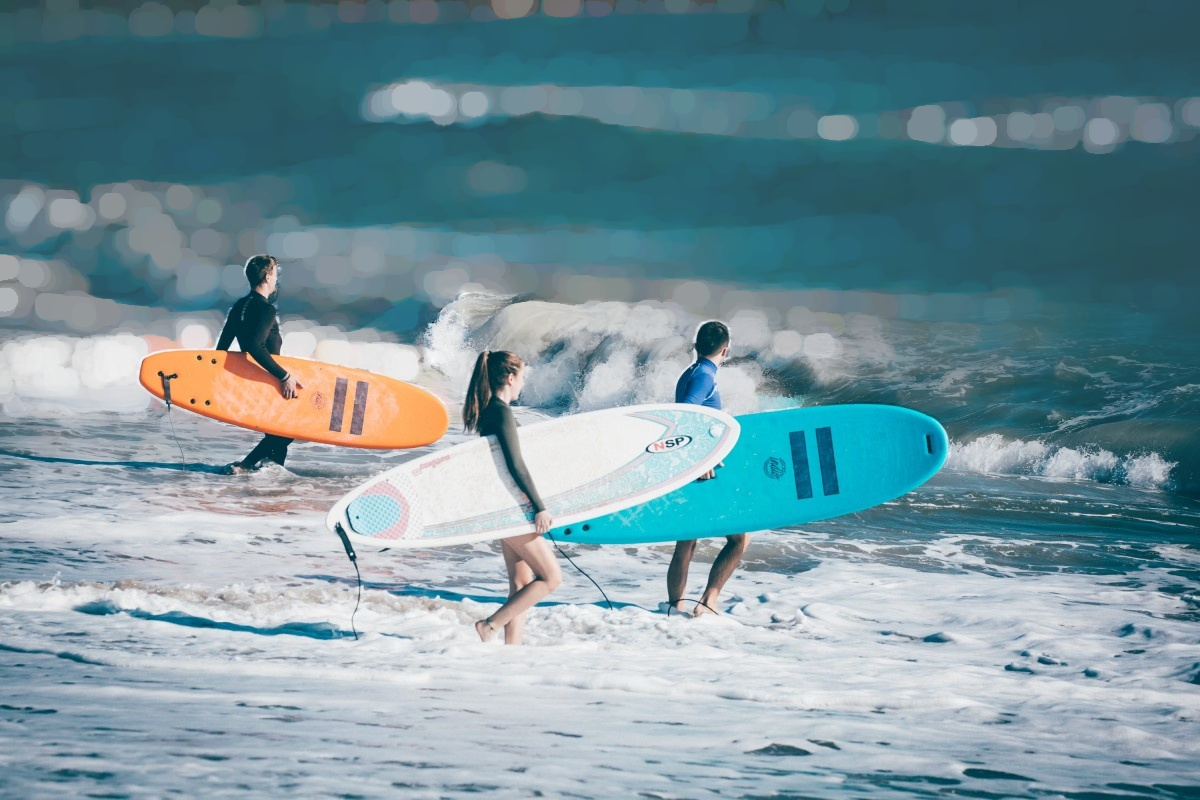

In [12]:
# COMPOSITE WITHOUT BACKGROUND GRADIENT

mask_img = Image.open(f"{os.getcwd()}/interpolation_mask.jpg").convert("L")
w = Image.fromarray(watercolor_img)
o= Image.fromarray(input_img)
res = Image.composite(o, w, mask_img)
res.save('result_no_grad.png')
res

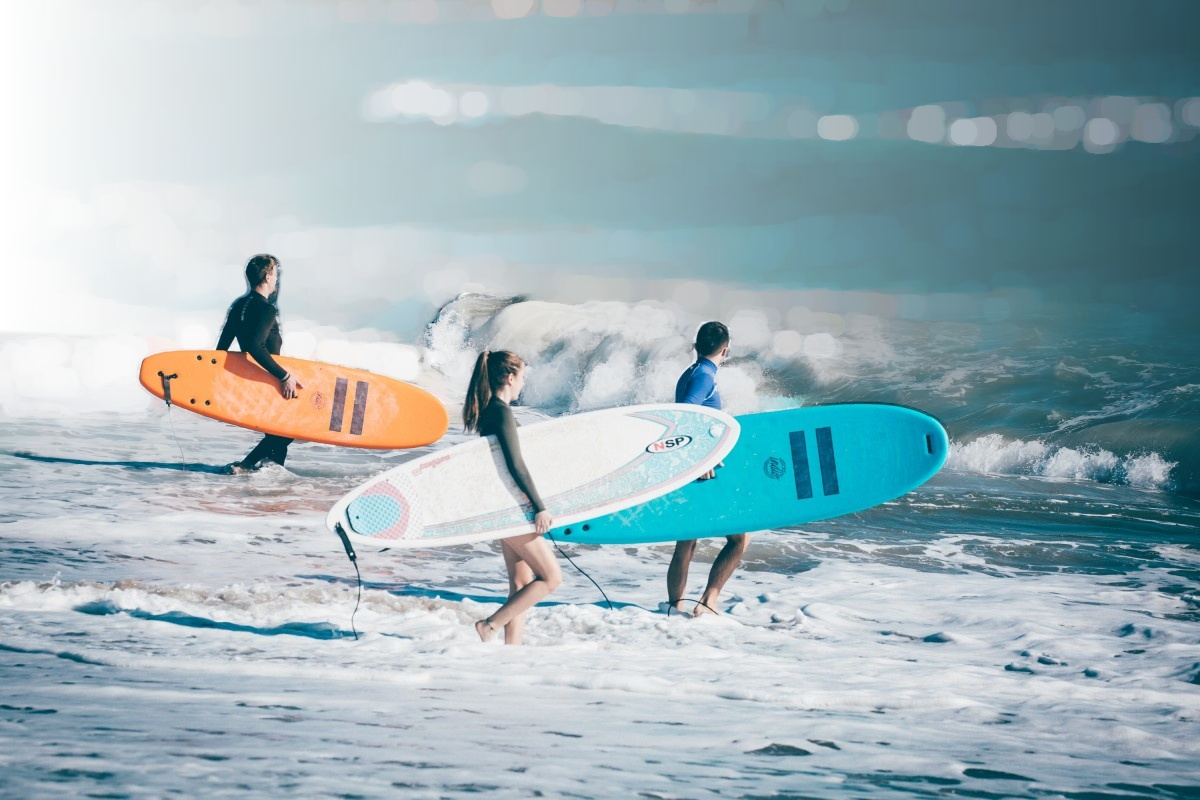

In [13]:
# COMPOSITE WITH BACKGROUND GRADIENT

w.putalpha(gradient)
res = Image.composite(o, w, mask_img)
res.save('result_with_grad.png')
res